# THINGS images - Exploring with CLIP

THINGS-images is a freely available database of 26,107 high quality, manually-curated images of 1,854 diverse object concepts, curated systematically from the everyday American English language and using a large-scale web search. Includes 27 high-level categories, semantic embeddings for all concepts, and more metadata.

There's a lot of interesting datasets that have been released based on this one, you can find them here:  
https://things-initiative.org/

You can explore all the categories and selectively download images you want here:
https://things-initiative.org/projects/things-images/

You're going to be using CLIP to explore this dataset, and hopefully discover some cool things about CLIP along the way.

In [1]:
import os

In [2]:
all_images = [x for x in os.listdir('THINGS_images/') if x.endswith('.jpg')]
categories = set([x[:-8] for x in all_images])
category2images = {category : [] for category in categories}
for img in all_images:
    category2images[img[:-8]].append(img)

In [3]:
all_images

['dog_06s.jpg',
 'cat_04s.jpg',
 'mango_01b.jpg',
 'mango_03s.jpg',
 'dog_01b.jpg',
 'cat_01b.jpg']

In [4]:
categories

{'cat', 'dog', 'mango'}

In [5]:
category2images['mango']

['mango_01b.jpg', 'mango_03s.jpg']

## Note
Turns out the text encoder bundled with the stable-diffusion-2-1-unclip doesn't project to the same image space.
So we're pulling the openCLIP text encoder from the official source, since the unCLIP vision encoder is the exact analogue from openCLIP.

In [6]:
import requests
import torch
from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO
import numpy as np
from tqdm import tqdm
import pandas as pd
import os

In [7]:
!pip install --upgrade diffusers[torch]
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [8]:
from diffusers import StableUnCLIPImg2ImgPipeline
from transformers import CLIPTextModelWithProjection, CLIPTokenizer

2025-12-04 09:12:41.838072: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-04 09:12:41.838128: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-04 09:12:41.839396: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-04 09:12:41.845522: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
# ──────────────────────────────────────────────────────────────
# 1.  Load unCLIP – vision side only (projection_dim = 1024)   ─
# ──────────────────────────────────────────────────────────────
pipe = StableUnCLIPImg2ImgPipeline.from_pretrained(
    "sd2-community/stable-diffusion-2-1-unclip",
    torch_dtype=torch.float16,
    variant="fp16"
).to(device)

vision_encoder = pipe.image_encoder                       # keep as-is (1024-d)

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

In [11]:
# ──────────────────────────────────────────────────────────────
# 2.  Swap in an OpenCLIP ViT-H/14 text branch (also 1024-d)  ─
# ──────────────────────────────────────────────────────────────
openclip_repo = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"     # projection_dim = 1024 :contentReference[oaicite:0]{index=0}
tokenizer = CLIPTokenizer.from_pretrained(openclip_repo)
text_encoder = CLIPTextModelWithProjection.from_pretrained(
    openclip_repo,
    torch_dtype=torch.float16
).to(device)

# optional: stuff them into the pipe so `pipe.tokenizer` etc. work
pipe.tokenizer, pipe.text_encoder = tokenizer, text_encoder

In [12]:
# ──────────────────────────────────────────────────────────────
# 3. Helpers                                              
# ──────────────────────────────────────────────────────────────
def embed_images(paths, batch_size=8):
    """Return (N,1024) image embeddings"""
    out, fe, enc = [], pipe.feature_extractor, pipe.image_encoder
    for i in range(0, len(paths), batch_size):
        imgs = [Image.open(p).convert("RGB") for p in paths[i:i + batch_size]]
        px   = fe(imgs, return_tensors="pt").pixel_values.to(enc.device, enc.dtype)
        with torch.no_grad():
            v = enc(px)[0]                              # (B,1024)
        out.append(v)
    return torch.cat(out)  # (N,1024)

def embed_texts(prompts, batch_size=64):
    """Return (N,1024) text embeddings"""
    vecs = []
    for i in range(0, len(prompts), batch_size):
        toks = tokenizer(prompts[i:i + batch_size],
                         padding=True, truncation=True, max_length=77,
                         return_tensors="pt").to(text_encoder.device)
        with torch.no_grad():
            t = text_encoder(**toks).text_embeds        # (B,1024)
        vecs.append(t)
    return torch.cat(vecs)  # (N,1024)
    

In [13]:
# ──────────────────────────────────────────────────────────────
# 4.  Sanity check on image-text similarity                                 
# ──────────────────────────────────────────────────────────────
img_vec = embed_images(["./THINGS_images/mango_03s.jpg"])
txt_vec = embed_texts(["mango"])
print("cosine(mango image, \"mango\") →",
      (torch.nn.functional.normalize(img_vec, dim=-1) @ torch.nn.functional.normalize(txt_vec, dim=-1).T).item())        
# expect ≳ 0.3

cosine(mango image, "mango") → 0.321533203125


In [14]:
# ──────────────────────────────────────────────────────────────
# 5.  Sanity check on image-image similarity                                 
# ──────────────────────────────────────────────────────────────
img_vec = embed_images(["./THINGS_images/mango_03s.jpg",
                       "./THINGS_images/cat_01b.jpg",
                       "./THINGS_images/dog_01b.jpg"])
img_vec2 = embed_images(["./THINGS_images/mango_01b.jpg",
                       "./THINGS_images/cat_04s.jpg",
                       "./THINGS_images/dog_06s.jpg"])

sims = torch.nn.functional.normalize(img_vec, dim=-1) @ torch.nn.functional.normalize(img_vec2, dim=-1).T 
sims = sims.detach().cpu().numpy()

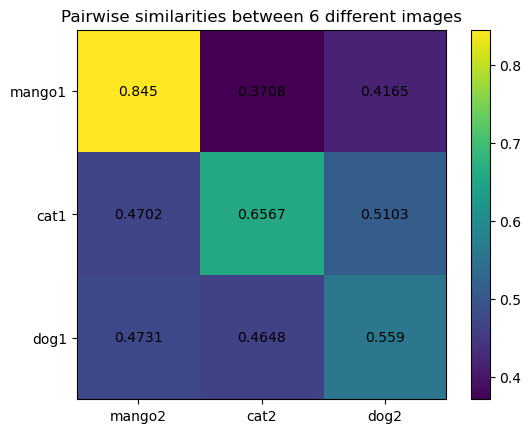

In [15]:
fig, ax = plt.subplots()

# Display the data as an image (heatmap)
im = ax.imshow(sims, cmap='viridis')

# Loop over the data and place text annotations
for i in range(sims.shape[0]):
    for j in range(sims.shape[1]):
        ax.text(j, i, sims[i, j], ha='center', va='center', color='black')

# Add a colorbar for reference
plt.colorbar(im)
plt.yticks([0, 1, 2], ['mango1', 'cat1', 'dog1'])
plt.xticks([0, 1, 2], ['mango2', 'cat2', 'dog2'])

# Set title and display the plot
ax.set_title('Pairwise similarities between 6 different images')
plt.show()